# Settings

In [8]:
loss_ckpt_path = "/home/borth/sketch2shape/checkpoints/siamese.ckpt"
shape_view_id = 11
shape_k = 16

In [1]:
from lib.utils.config import load_config
from lib.data.sampler import ChunkSampler
from lib.data.metainfo import MetaInfo

cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir, split="train_latent")
metainfo.load_snn()
sampler = ChunkSampler(metainfo.snn_labels, chunk_size=1)
max([i for i in sampler])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


714223

# Utils

In [3]:
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
from lib.visualize.image import image_grid


def transform(normal):
    _transform = BaseTransform()
    return _transform(normal).to("cuda")


def plot_images(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image)
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images)
        plt.show()


def siamese_loss(emb_1, emb_2):
    return 1 - cosine_similarity(emb_1, emb_2)

# Load Models

In [9]:
cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)

cfg.loss_ckpt_path = loss_ckpt_path
cfg.model.shape_k = shape_k
cfg.model.shape_view_id = shape_view_id
cfg.model.shape_init = True
cfg.model.obj_id = metainfo.obj_ids[0]
model = hydra.utils.instantiate(cfg.model).to("cuda")

sketch_3 = np.asarray(metainfo.load_image(3, 11, 0))
sketch_5 = np.asarray(metainfo.load_image(5, 11, 0))
model.latent = model.deepsdf.lat_vecs.weight[3]
rendered_normal_3 = model.capture_camera_frame().detach().cpu().numpy()

rendered_normal_3_emb = model.siamese(transform(rendered_normal_3)[None, ...])
sketch_3_emb = model.siamese(transform(sketch_3)[None, ...])
sketch_5_emb = model.siamese(transform(sketch_5)[None, ...])

print(f"{siamese_loss(sketch_3_emb, rendered_normal_3_emb)=}")
plot_images([sketch_3, rendered_normal_3])

print(f"{siamese_loss(sketch_5_emb, rendered_normal_3_emb)=}")
plot_images([sketch_5, rendered_normal_3])

tensor(3176, device='cuda:0') tensor(1.3905, device='cuda:0')
tensor(2733, device='cuda:0') tensor(0.6279, device='cuda:0')
tensor(94, device='cuda:0') tensor(0.5715, device='cuda:0')
tensor(2110, device='cuda:0') tensor(1.2953, device='cuda:0')
tensor(934, device='cuda:0') tensor(0.6432, device='cuda:0')
tensor(2317, device='cuda:0') tensor(0.7866, device='cuda:0')
tensor(2930, device='cuda:0') tensor(0.8836, device='cuda:0')
tensor(2735, device='cuda:0') tensor(0.9638, device='cuda:0')
tensor(3831, device='cuda:0') tensor(1.5329, device='cuda:0')
tensor(3400, device='cuda:0') tensor(0.7058, device='cuda:0')
tensor(1604, device='cuda:0') tensor(0.5827, device='cuda:0')
tensor(3928, device='cuda:0') tensor(0.8574, device='cuda:0')
tensor(2793, device='cuda:0') tensor(0.7160, device='cuda:0')
tensor(1982, device='cuda:0') tensor(1.0227, device='cuda:0')
tensor(1387, device='cuda:0') tensor(1.6164, device='cuda:0')
tensor(313, device='cuda:0') tensor(0.8038, device='cuda:0')


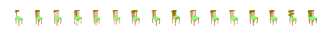

In [12]:
std = model.shape_latents.std(0)
mean = model.shape_latents.mean(0)
loss= []
images = []
for idx in model.shape_idx:
    reg_loss = ((model.deepsdf.lat_vecs.weight[idx] - mean) / std).pow(2)
    model.latent = model.deepsdf.lat_vecs.weight[idx]
    rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
    images.append(rendered_normal)
    rendered_normal_emb = model.siamese(transform(rendered_normal_3)[None, ...])
    loss.append(reg_loss.mean().item())
    print(idx, reg_loss.mean())
plot_images(images)

In [73]:
rendered_normal = model.capture_camera_frame()
mean = rendered_normal.mean(-1, keepdim=True)
# print(mean.shape)
mean.expand_as(rendered_normal)

torch.Size([256, 256, 3])

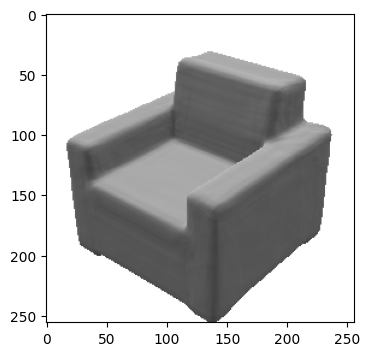

tensor([0.0739], device='cuda:0')

In [6]:
model.latent = model.deepsdf.lat_vecs.weight[3]
model.deepsdf.create_camera(azim=-40, elev=-30)
rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
mean = rendered_normal.mean(-1)
mean = np.stack([mean, mean,mean], axis=-1)
rendered_gray_emb = model.siamese(transform(mean)[None, ...])
plot_images(mean)
siamese_loss(rendered_gray_emb, sketch_3_emb)

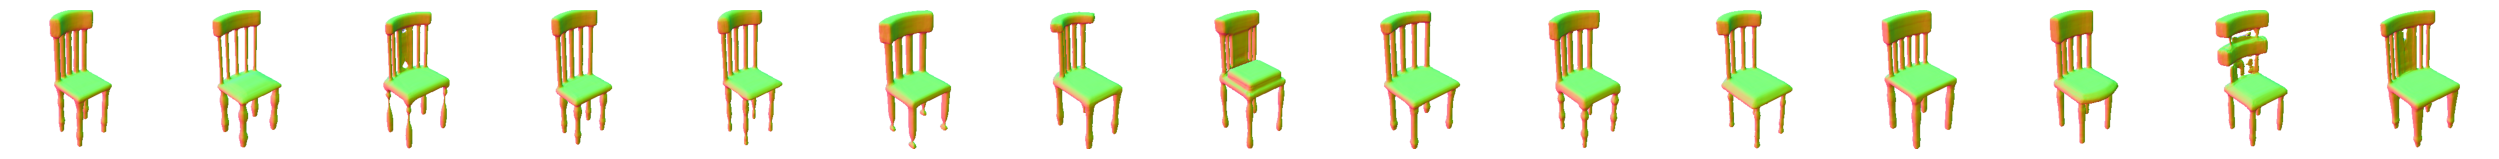

0.628
0.571
1.3
0.643
0.787
0.884
0.964
1.53
0.706
0.583
0.857
0.716
1.02
1.62
0.804


In [20]:
plot_images(images[1:], size=32)
for l in loss[1:]:
    print(f"{l:.03}")

tensor([3176, 2733,   94, 2110,  934, 2317, 2930, 2735, 3831, 3400, 1604, 3928,
        2793, 1982, 1387,  313], device='cuda:0')
siamese_loss(sketch_3_emb, rendered_normal_emb)=tensor([0.0342], device='cuda:0')


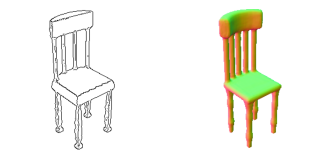

In [10]:
print(model.shape_idx)
model.latent = model.deepsdf.lat_vecs.weight[2733]
rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
rendered_normal_emb = model.siamese(transform(rendered_normal_3)[None, ...])

print(f"{siamese_loss(sketch_3_emb, rendered_normal_emb)=}")
plot_images([sketch_3, rendered_normal])

6/6: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


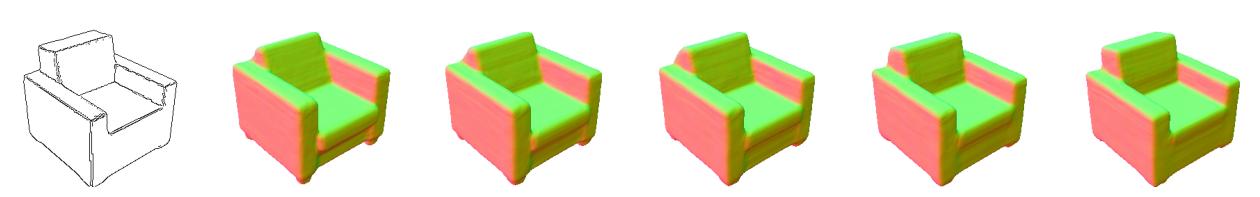

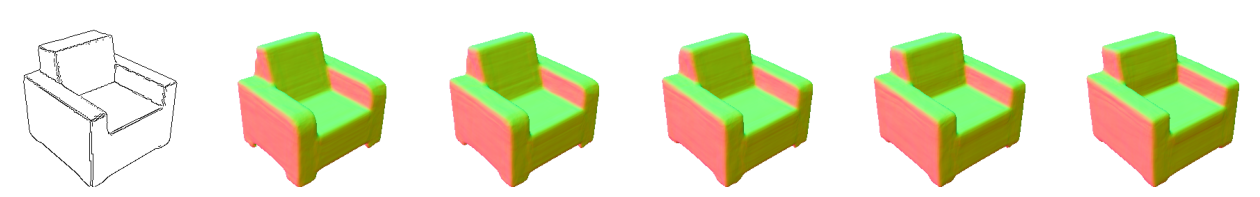

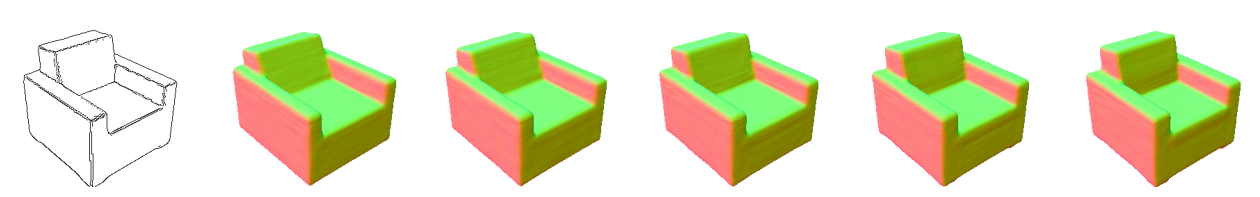

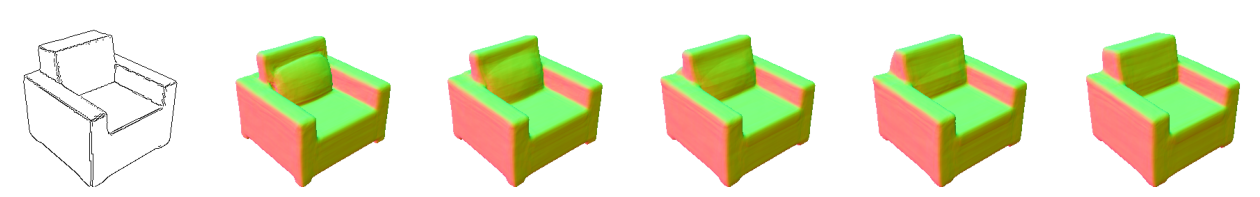

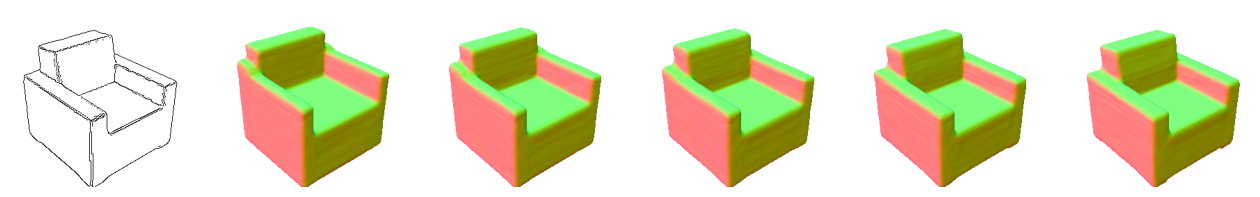

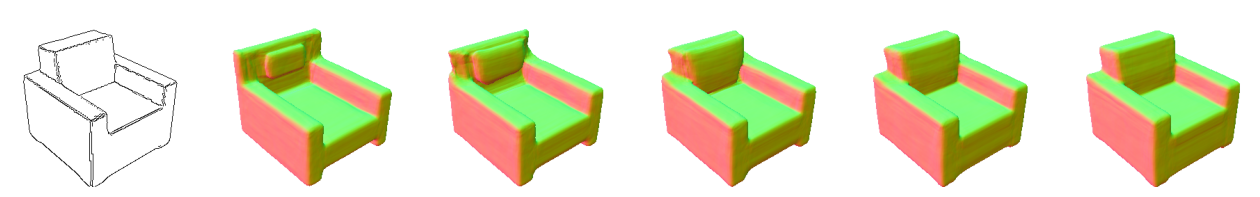

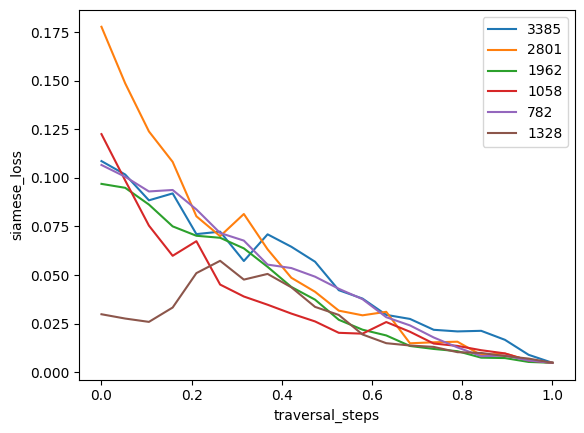

Text(0.5, 0, 'traversal_steps')

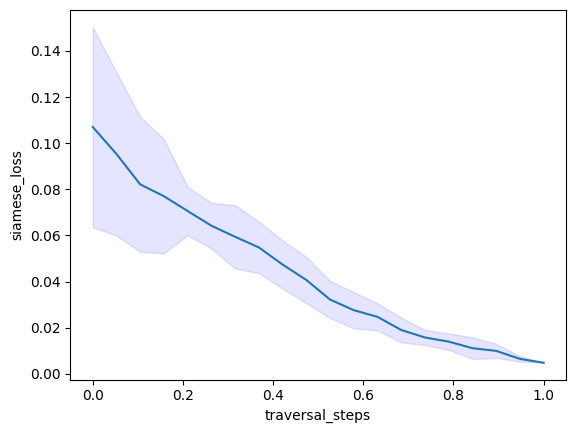

In [57]:
# settings
start_latent_ids = [3385, 2801, 1962, 1058, 782, 1328]  # couch nn
# start_latent_ids = [3, 0, 1, 2, 4, 5, 6] # couch far
# start_latent_ids = [3, 0, 1, 2, 4, 5, 6] # couch far
# start_latent_ids = [0, 5]  # couch far
end_latent_id = 3
sketch_view = 11
traversal_steps = 20
image_skip = 4
azims = [40]
elevs = [-30]

# fetch and encode the sketch
sketch = metainfo.load_image(end_latent_id, sketch_view, 0)
sketch_emb = model.siamese(transform(sketch)[None, ...])

image_trajectories = []
loss_trajectories = []
for idx, start_latent_id in enumerate(start_latent_ids):
    image_trajectory = [sketch]
    loss_trajectory = []
    desc = f"{idx+1}/{len(start_latent_ids)}"
    for t in tqdm(np.linspace(1, 0, traversal_steps), desc=desc):
        start_latent = model.deepsdf.lat_vecs.weight[start_latent_id]
        end_latent = model.deepsdf.lat_vecs.weight[end_latent_id]
        model.latent = t * start_latent + (1 - t) * end_latent

        # calculate the mean loss from all the views
        loss = []
        for azim in azims:
            for elev in elevs:
                model.deepsdf.create_camera(azim=azim, elev=elev)
                rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
                # mean = rendered_normal.mean(-1)
                # rendered_normal = np.stack([mean, mean,mean], axis=-1)
                rendered_normal_emb = model.siamese(
                    transform(rendered_normal)[None, ...]
                )
                snn_loss = siamese_loss(sketch_emb, rendered_normal_emb)
                loss.append(snn_loss)
                image_trajectory.append(rendered_normal)
        loss = torch.stack(loss).mean()

        # add the loss to the trajectory
        loss_trajectory.append(loss.detach().cpu().numpy())
    loss_trajectories.append(loss_trajectory)
    image_trajectories.append(image_trajectory)

# plot the images
for image_trajectory in image_trajectories:
    trajectory = []
    for idx, img in enumerate(image_trajectory):
        if idx == 0 or (idx - 1) % image_skip == 0:
            trajectory.append(img)
    plot_images(trajectory, size=16)

# plot the loss curves
for obj_id, loss_trajectory in zip(start_latent_ids, loss_trajectories):
    plt.plot(
        np.linspace(0, 1, traversal_steps),
        np.stack(loss_trajectory),
        label=obj_id,
    )
    plt.legend(loc="upper right")
plt.ylabel("siamese_loss")
plt.xlabel("traversal_steps")
plt.show()

x = np.linspace(0, 1, 20)
mean = np.stack(loss_trajectories).mean(0)
std = np.stack(loss_trajectories).std(0)
plt.plot(x, mean)
plt.fill_between(x, (mean - std), (mean + std), color="b", alpha=0.1)
plt.ylabel("siamese_loss")
plt.xlabel("traversal_steps")

In [ ]:
model.latent = model.deepsdf.lat_vecs.weight[0]
normal = model.capture_camera_frame().detach().cpu().numpy()
normal_emb = model.siamese(transform(normal)[None, ...])
print(f"{siamese_loss(sketch_3_emb, normal_emb)=}")
plot_images([sketch_3, normal])

In [ ]:
"""
tensor(2549, device='cuda:0') tensor(0.6049, device='cuda:0')
tensor(1328, device='cuda:0') tensor(1.4948, device='cuda:0')
tensor(1898, device='cuda:0') tensor(0.6908, device='cuda:0')
tensor(962, device='cuda:0') tensor(0.6423, device='cuda:0')
tensor(535, device='cuda:0') tensor(0.8771, device='cuda:0')
tensor(755, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(2432, device='cuda:0') tensor(1.8280, device='cuda:0')
tensor(3089, device='cuda:0') tensor(0.9243, device='cuda:0')
tensor(3885, device='cuda:0') tensor(1.6862, device='cuda:0')
tensor(1447, device='cuda:0') tensor(1.0207, device='cuda:0')
tensor(3195, device='cuda:0') tensor(0.8885, device='cuda:0')
tensor(2207, device='cuda:0') tensor(0.7391, device='cuda:0')
tensor(277, device='cuda:0') tensor(0.7135, device='cuda:0')
tensor(1058, device='cuda:0') tensor(0.6626, device='cuda:0')
tensor(841, device='cuda:0') tensor(1.0481, device='cuda:0')
tensor(1637, device='cuda:0') tensor(0.6819, device='cuda:0')
"""

model.latent = model.deepsdf.lat_vecs.weight[3885]
normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(normal)

mean = model.shape_latents.mean(0)
std = model.shape_latents.std(0)

good_latents = []
for i in range(4096):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    if reg_loss <= 1.0 and i != 3:
        good_latents.append(latent)

for i in range(5):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    print("init", i, reg_loss)

mean = torch.stack(good_latents).mean(0)
std = torch.stack(good_latents).std(0)
for i in range(5):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    print("good", i, reg_loss)

In [ ]:
for i in range(4096):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    if reg_loss <= 1.0:
        print(i, reg_loss)

In [ ]:
model.latent = model.deepsdf.lat_vecs.weight[1962]
normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(normal)
# mean = model.shape_latents.mean(0)
# std = model.shape_latents.std(0)
# mean = torch.stack(good_latents).mean(0)
# std = torch.stack(good_latents).std(0)

((mean - latent) / std).pow(2).mean()

# Optimize Latent Code (Simple)

In [ ]:
start_latent_id = 3385
end_latent_id = 3
optim_steps = 10

t = torch.tensor(1.0, dtype=torch.float32).to("cuda")
t.requires_grad = True
start_latent = model.deepsdf.lat_vecs.weight[start_latent_id]
start_latent.requires_grad = True
end_latent = model.deepsdf.lat_vecs.weight[end_latent_id]
end_latent.requires_grad = True

optimizer = torch.optim.Adam([t], lr=0.1)

sketch = metainfo.load_image(end_latent_id, 11, 0)
sketch_emb = model.siamese(transform(sketch)[None, ...])

image_trajectory = [np.asarray(sketch)]
loss_trajectory = []
reg_loss_trajectory = []
t_trajectory = []
with tqdm(total=optim_steps) as pbar:
    for step in range(optim_steps):
        model.latent = t * start_latent + (1 - t) * end_latent
        points, surface_mask = model.deepsdf.sphere_tracing(
            latent=model.latent,
            points=model.deepsdf.camera_points,
            rays=model.deepsdf.camera_rays,
            mask=model.deepsdf.camera_mask,
        )
        rendered_normal = model.deepsdf.render_normals(
            latent=model.latent,
            points=points,
            mask=surface_mask,
        )  # (H, W, 3)
        normal = model.deepsdf.normal_to_siamese(rendered_normal)  # (1, 3, H, W)
        normal_emb = model.siamese(normal)  # (1, D)

        snn_loss = siamese_loss(sketch_emb, normal_emb)

        std = model.shape_latents.std(0)
        mean = model.shape_latents.mean(0)
        reg_loss = ((model.latent.clone() - mean) / std).pow(2)
        reg_loss_trajectory.append(reg_loss.mean().item())

        loss_trajectory.append(snn_loss.item())
        t_trajectory.append(t.item())
        image_trajectory.append(rendered_normal.detach().cpu().numpy())

        snn_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_postfix({"t": t.item()})
        pbar.update(1)

# images
plot_images(image_trajectory, size=16)

# loss
plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(loss_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("siamese_loss")
plt.xlabel("optim_steps")
plt.show()

plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(reg_loss_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("reg_loss")
plt.xlabel("optim_steps")
plt.show()

plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(t_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("t")
plt.xlabel("optim_steps")
plt.show()